In [1]:
import os
import datetime
import errno

import numpy as np

import deepcell
from deepcell.utils.tracking_utils import load_trks, trks_stats
from deepcell.utils.misc_utils import sorted_nicely
from deepcell.utils.tracking_utils import load_trks

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Cell segmentation

In [2]:
from deepcell.utils.data_utils import get_data
from tensorflow.keras.utils import get_file

def load_data(path, mode, test_size=0.2, seed=0):
    """Loads dataset.
    Args:
         test_size (float): fraction of data to reserve as test data
        seed (int): the seed for randomly shuffling the dataset
    Returns:
           tuple: (x_train, y_train), (x_test, y_test).
    """
    basepath = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
    prefix = path.split(os.path.sep)[:-1]
    data_dir = os.path.join(basepath, *prefix) if prefix else basepath
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    elif not os.path.isdir(data_dir):
        raise IOError('{} exists but is not a directory'.format(data_dir))

    train_dict, test_dict = get_data(
        path,
        mode=mode,
        test_size=test_size,
        seed=seed)
    x_train, y_train = train_dict['X'], train_dict['y']
    x_test, y_test = test_dict['X'], test_dict['y']
    return (x_train, y_train), (x_test, y_test)

## Create fgbg model

In [3]:
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data  ## 61
n_skips = 1  # number of skip-connections (only for FC training)

# pixelwise transform settings
dilation_radius = 1  # change dilation radius for edge dilation
separate_edge_classes = True  # break edges into cell-background edge, cell-cell edge
pixelwise_kwargs = {
    'dilation_radius': dilation_radius,
    'separate_edge_classes': separate_edge_classes,
}

input_shape=(530, 530, 1)

from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    norm_method=norm_method,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=input_shape,
    last_only=False)

In [4]:
fgbg_model.load_weights("../seg_train_0816_convol/models/test/conv_fgbg_model.h5")

## Create pixelwise model

In [5]:
pixelwise_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    n_features=4 if separate_edge_classes else 3,
    receptive_field=receptive_field,
    norm_method=norm_method,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=input_shape)

In [6]:
pixelwise_model.load_weights("../seg_train_0816_convol/models/test/conv_edgeseg_model.h5")

## Post-processing

In [12]:
test = np.load("../test.npz")
x = test['X']
print(x.shape)

(66, 100, 530, 530, 1)


In [14]:
images = pixelwise_model.predict(x[0])[-1]
images_fgbg = fgbg_model.predict(x[0])[-1]

In [39]:
# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.8

fg_thresh = images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

images_post_fgbg = images * fg_thresh

In [16]:
# Label interior predictions
from skimage.measure import label
from skimage import morphology

labeled_images = []
for i in range(images_post_fgbg.shape[0]):
    interior = images_post_fgbg[i, ..., 2] > .5
    labeled_image = label(interior)
    labeled_image = morphology.remove_small_objects(
        labeled_image, min_size=130, connectivity=1)  ## min_size=50
    labeled_images.append(labeled_image)
labeled_images = np.array(labeled_images)
labeled_images = np.expand_dims(labeled_images, axis=-1)  

print('labeled_images shape:', labeled_images.shape)

labeled_images shape: (100, 530, 530, 1)


In [17]:
images.shape

(100, 530, 530, 4)

Image number: 3


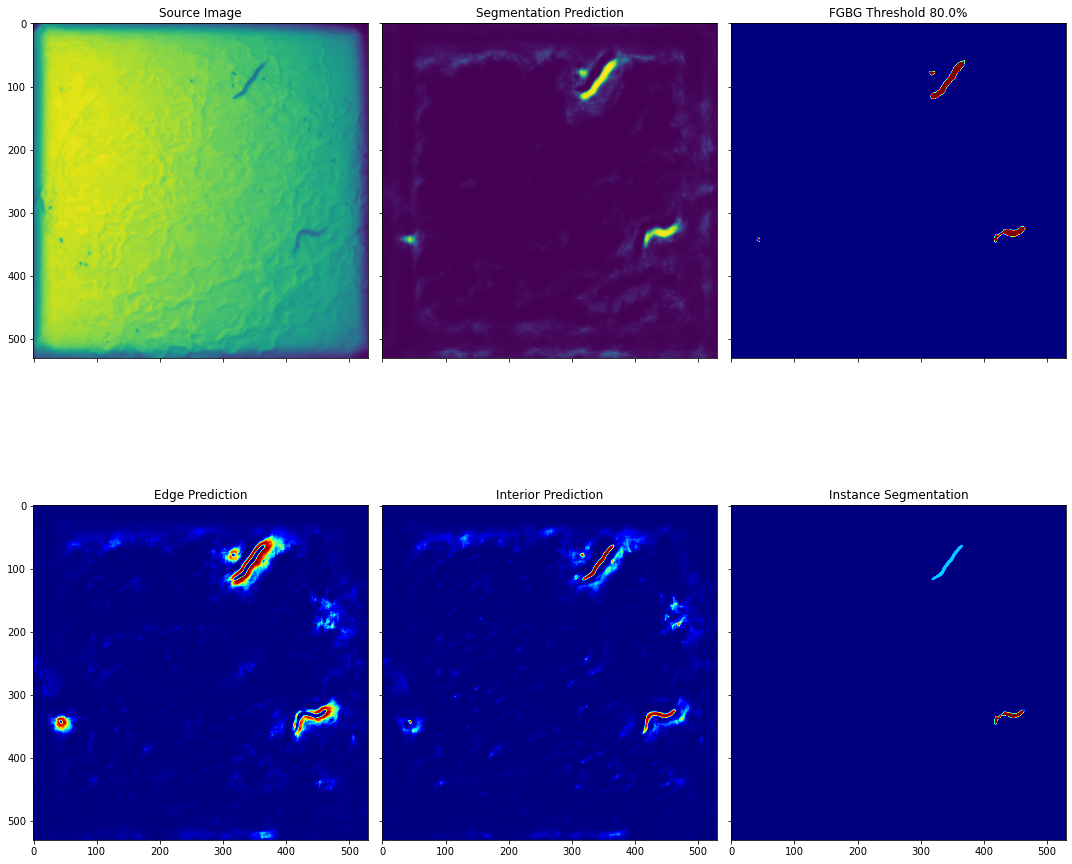

In [22]:
import matplotlib.pyplot as plt

#index = np.random.randint(low=0, high=X_test.shape[0])

index = 3
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(x[0][index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(images[index, ..., 0] + images[index, ..., 1], cmap='jet')
ax[3].set_title('Edge Prediction')

ax[4].imshow(images[index, ..., 2], cmap='jet')
ax[4].set_title('Interior Prediction')

ax[5].imshow(labeled_images[index, ..., 0], cmap='jet')
ax[5].set_title('Instance Segmentation')



fig.tight_layout()
plt.show()

In [ ]:
#---------------------------------------------------------------------------------------------

In [25]:
d7 = np.load("../6819_3/D7_raw_1.npy")
x = d7

In [26]:
x.shape

(100, 530, 530, 1)

In [31]:
images = pixelwise_model.predict(x)[-1]
images_fgbg = fgbg_model.predict(x)[-1]

In [40]:
images.shape

(100, 530, 530, 4)

In [41]:
# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.8

fg_thresh = images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

images_post_fgbg = images * fg_thresh

In [54]:
image_list = []

labeled_images = []
for i in range(images_post_fgbg.shape[0]):
    interior = images_post_fgbg[i, ..., 2] > .5
    labeled_image = label(interior)
    labeled_image = morphology.remove_small_objects(
        labeled_image, min_size=130, connectivity=1)  ## min_size=50
    labeled_images.append(labeled_image)
labeled_images = np.array(labeled_images)
labeled_images = np.expand_dims(labeled_images, axis=-1) 
    
image_list.append(labeled_images)

#labeled_images = []
#for i in range(images_post_fgbg.shape[0]):
#    interior = images_post_fgbg[i, ..., 2] > .5
#    labeled_image = label(interior)
#    labeled_image = morphology.remove_small_objects(
#        labeled_image, min_size=130, connectivity=1)  ## min_size=50
#    labeled_images.append(labeled_image)
#labeled_images = np.array(labeled_images)
#labeled_images = np.expand_dims(labeled_images, axis=-1)  

print('labeled_images shape:', labeled_images.shape)

labeled_images shape: (100, 530, 530, 1)


Image number: 99


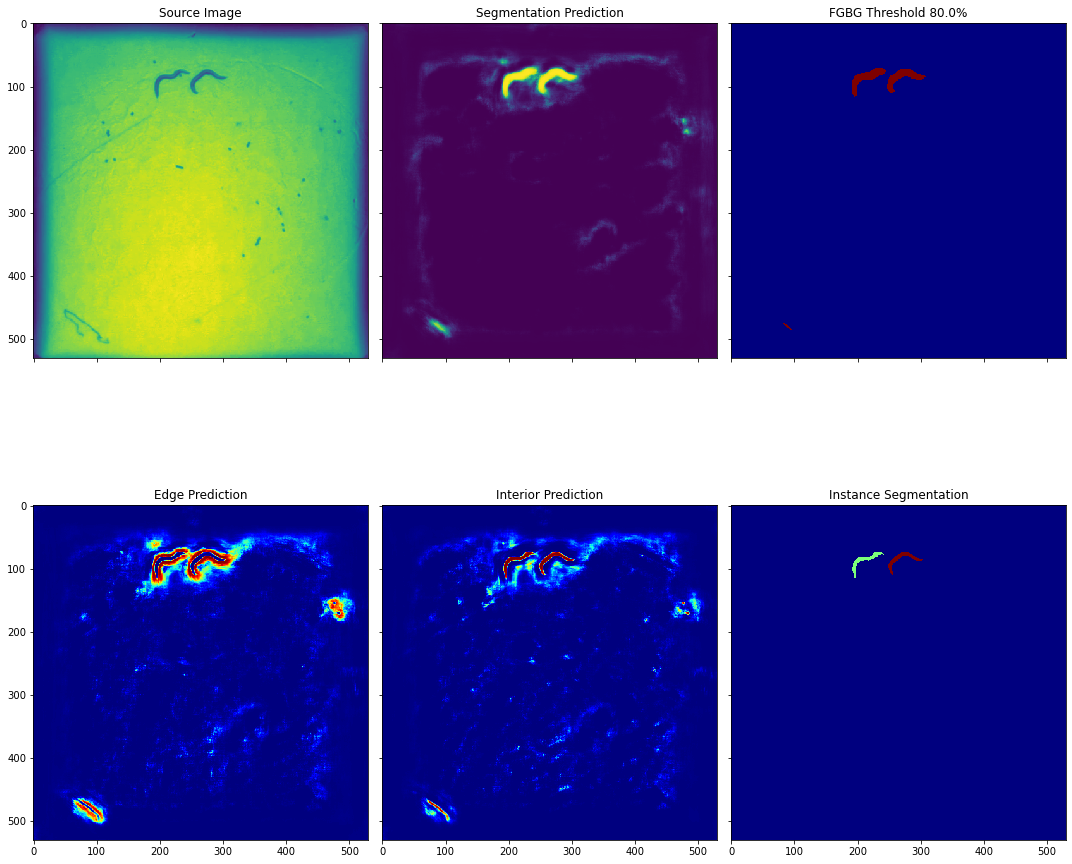

In [55]:
import matplotlib.pyplot as plt

#index = np.random.randint(low=0, high=X_test.shape[0])

index = 99
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(x[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(images[index, ..., 0] + images[index, ..., 1], cmap='jet')
ax[3].set_title('Edge Prediction')

ax[4].imshow(images[index, ..., 2], cmap='jet')
ax[4].set_title('Interior Prediction')

ax[5].imshow(labeled_images[index, ..., 0], cmap='jet')
ax[5].set_title('Instance Segmentation')



fig.tight_layout()
plt.show()

unique_worm_ids:  [1, 2]
sequential ids:  [1, 2]


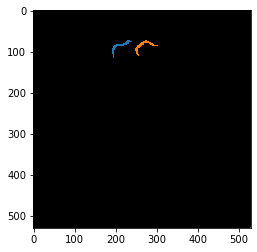

In [56]:
# save as gif
import gif
gif.plot_gif(labeled_images, '../segmented/6819_3/D7_seg_1.gif')

In [62]:
# Save the labeled_images into .npy

np.save('../segmented/6819_3/D7_seg_1.npy', labeled_images)

## Cell tracking

In [28]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = 'test_0817'

ROOT_DIR = '../train_0817'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

In [40]:
from deepcell import model_zoo

# Tracking model settings (These settings should mirror those from Part 1)
features = {'appearance', 'distance', 'neighborhood', 'regionprop'}
min_track_length = 9
neighborhood_scale_size = 30
batch_size = 16  # changed  
crop_dim = 100  # changed
in_shape = (crop_dim, crop_dim, 1)

# Re-instantiate the tracking model
tracking_model = model_zoo.siamese_model(
    input_shape=in_shape,
    neighborhood_scale_size=neighborhood_scale_size,
    features=features)

# Load model weights
siamese_weights_file = 'tracking_model_seed1_tl9.h5'
siamese_weights_file = os.path.join(MODEL_DIR, siamese_weights_file)

tracking_model.load_weights('../train_0817/models/test_0817/tracking_model_seed1_tl9.h5')

print(in_shape)

(100, 100, 1)


In [41]:
tracking_model

In [42]:
division = [0.9]
birth = [0.99]
death = [0.99]
max_distance = 50
track_length = 9
neighborhood_scale_size = 5

In [43]:
import deepcell.tracking

In [44]:
seg = np.load("../segmented/6819_3/D7_seg_1.npy")
raw = np.load("../6819_3/D7_raw_1.npy")

In [45]:
print(raw.shape)
print(seg.shape)

(100, 530, 530, 1)
(100, 530, 530, 1)


In [46]:
def image_norm(img):
    return (img - np.mean(img)) / np.std(img)

# Go through each batch (movie) in each dataset    
for frame in range(raw.shape[0]):
    raw[frame, :, :, 0] = image_norm(raw[frame, :, :, 0]) 

In [47]:
trial = deepcell.tracking.cell_tracker(
    raw, seg, tracking_model,
    max_distance=max_distance,
    track_length=track_length,
    division=division[0],
    birth=birth[0],
    death=death[0],
    neighborhood_scale_size=neighborhood_scale_size,
    features=features)

In [48]:
trial.y.shape

(100, 530, 530, 1)

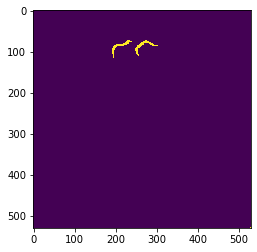

In [49]:
import matplotlib.pyplot as plt

plt.imshow(trial.y[99])

In [50]:
np.unique(trial.y)

array([  0, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390,
       391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403,
       404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416,
       417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429,
       430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
       443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455,
       456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
       469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 48

unique_worm_ids:  [301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 4

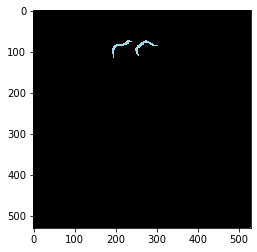

In [51]:
import gif
gif.plot_gif_more(trial.y, '../tracked/6819_3/D7_tracked_1.gif')

## Seg and t rack 6823_3 A10_mask_1

In [54]:
d7 = np.load("../6823_3/A10_raw_1.npy")
x = d7

print(x.shape)

images = pixelwise_model.predict(x)[-1]
images_fgbg = fgbg_model.predict(x)[-1]

(100, 530, 530, 1)


In [55]:
# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.5

fg_thresh = images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

images_post_fgbg = images * fg_thresh

In [56]:
from skimage.measure import label
from skimage import morphology

labeled_images = []
for i in range(images_post_fgbg.shape[0]):
    interior = images_post_fgbg[i, ..., 2] > .5
    labeled_image = label(interior)
    labeled_image = morphology.remove_small_objects(
        labeled_image, min_size=50, connectivity=1)  ## min_size=50
    labeled_images.append(labeled_image)
labeled_images = np.array(labeled_images)
labeled_images = np.expand_dims(labeled_images, axis=-1) 


print('labeled_images shape:', labeled_images.shape)

labeled_images shape: (100, 530, 530, 1)


Image number: 0


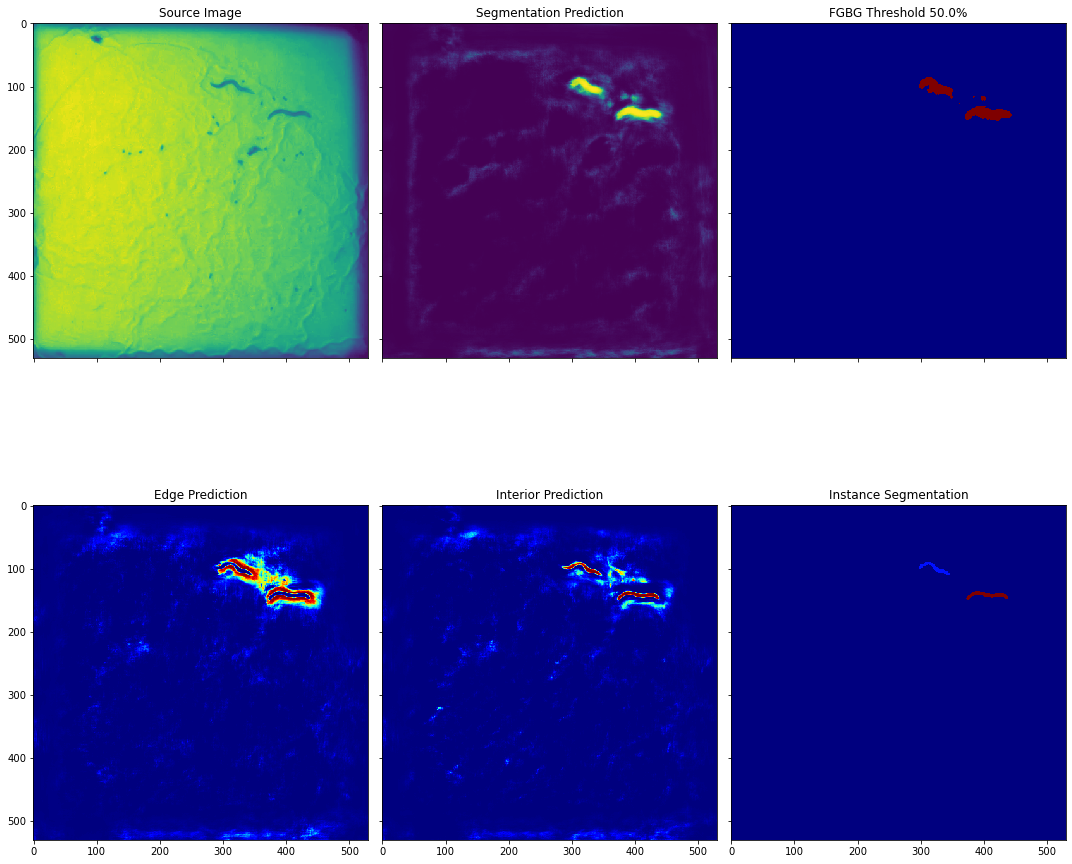

In [57]:
import matplotlib.pyplot as plt

#index = np.random.randint(low=0, high=X_test.shape[0])

index = 0
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(x[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(images[index, ..., 0] + images[index, ..., 1], cmap='jet')
ax[3].set_title('Edge Prediction')

ax[4].imshow(images[index, ..., 2], cmap='jet')
ax[4].set_title('Interior Prediction')

ax[5].imshow(labeled_images[index, ..., 0], cmap='jet')
ax[5].set_title('Instance Segmentation')



fig.tight_layout()
plt.show()

unique_worm_ids:  [1, 2, 3, 4, 5]
sequential ids:  [1, 2, 3, 4, 5]


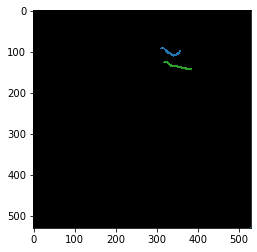

In [20]:
# save as gif
import gif
gif.plot_gif(labeled_images, '../segmented/6823_3/A10_seg_1.gif')

In [58]:
np.save('../segmented/6823_3/A10_seg_1.npy', labeled_images)

In [51]:
labeled_images = []
for i in range(images.shape[0]):
    interior = images[i, ..., 2] > .5
    labeled_image = label(interior)
    labeled_image = morphology.remove_small_objects(
        labeled_image, min_size=150, connectivity=1)  ## min_size=50
    labeled_images.append(labeled_image)
labeled_images = np.array(labeled_images)
labeled_images = np.expand_dims(labeled_images, axis=-1) 


print('labeled_images shape:', labeled_images.shape)

labeled_images shape: (100, 530, 530, 1)


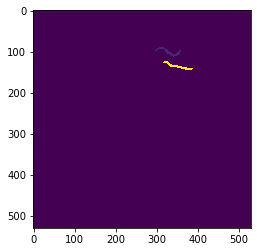

In [52]:
plt.imshow(labeled_images[99])

unique_worm_ids:  [1, 2, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
sequential ids:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


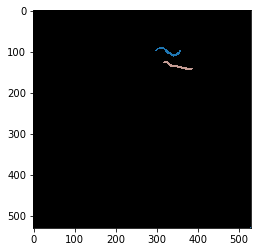

In [53]:
gif.plot_gif(labeled_images, "../segmented/6823_3/A19_seg_nofgbg_1.gif")

In [ ]:
# Save the labeled_images as .npy
np.save('../segmented/6823_3/A10_seg_nofgbg_1.npy', labeled_images)

##### Tracking

In [68]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = 'test_0818'

ROOT_DIR = '../train_0818'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

In [70]:
from deepcell import model_zoo

# Tracking model settings (These settings should mirror those from Part 1)
features = {'appearance', 'distance', 'neighborhood', 'regionprop'}
min_track_length = 9
neighborhood_scale_size = 30
batch_size = 16  # changed  
crop_dim = 40  # changed
in_shape = (crop_dim, crop_dim, 1)

# Re-instantiate the tracking model
tracking_model = model_zoo.siamese_model(
    input_shape=in_shape,
    neighborhood_scale_size=neighborhood_scale_size,
    features=features)

# Load model weights
siamese_weights_file = 'tracking_model_seed1_tl9.h5'
siamese_weights_file = os.path.join(MODEL_DIR, siamese_weights_file)

tracking_model.load_weights('../train_0818/models/test_0818/tracking_model_seed1_tl9.h5')

print(in_shape)

ValueError: axes don't match array

In [61]:
division = [0.9]
birth = [0.99]
death = [0.99]
max_distance = 50
track_length = 9
neighborhood_scale_size = 5

In [63]:
import deepcell.tracking

In [62]:
seg = np.load("../segmented/6823_3/A10_seg_1.npy")
raw = np.load("../6823_3/A10_raw_1.npy")

In [64]:
def image_norm(img):
    return (img - np.mean(img)) / np.std(img)

# Go through each batch (movie) in each dataset    
for frame in range(raw.shape[0]):
    raw[frame, :, :, 0] = image_norm(raw[frame, :, :, 0]) 

In [65]:
trial = deepcell.tracking.cell_tracker(
    raw, seg, tracking_model,
    max_distance=max_distance,
    track_length=track_length,
    division=division[0],
    birth=birth[0],
    death=death[0],
    neighborhood_scale_size=neighborhood_scale_size,
    features=features)

In [66]:
trial.y.shape

(100, 530, 530, 1)

unique_worm_ids:  [204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 4

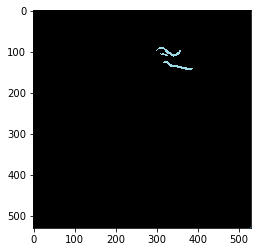

In [67]:
gif.plot_gif(trial.y, '../tracked/6823_3/A10_tracked_1.gif')

In [ ]:
np.save('../tracked/6823_3/A10_tracked_1.npy', trial.y)